# Structure MCMC - 3 Node DAG Experiments

In [44]:
import os
import random

import numpy as np
import pandas as pd

import arviz as az


import networkx as nx
import matplotlib.pyplot as plt

from scores.ScoreAbstract import Score
from scores.bge import BGEscore, BGEscoreEfficient
from scores.marginal import MarginalLogLikelihood


from cache import Cache


from mcmc.MCMCResultsEngine import MCMCResultsEngine


from evaluation.metrics import *

from utils.graph_utils import *

from proposals.graph.GraphProposal import GraphProposalUniform

from mcmc.StructureMCMC import StructureMCMC


import seaborn as sns
sns.set()




## Data Generation Process

In [57]:
# make a function that generates data for 3 random variables X1, X2, Y where Y = b0 + b1*X1 + b2*X2 + e
def generate_data(n, b0, b1, b2, e, random_seed = 55):
    
    np.random.seed(random_seed)
    
    X1 = np.random.normal(0, 1, n)
    X2 = np.random.normal(0, 1, n)
        
    random.seed(random_seed)
    # e follows a normal distribution    
    Y = b0 + b1*X1 + b2*X2 + np.random.normal(0, e, n)
    #Y = b0 + b1*X1 + np.random.normal(0, e, n)
    #Y = b0  + np.random.normal(0, e, n)
    
    #result = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})
    result = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})
    #result = pd.DataFrame({'X1': X1, 'Y': Y})
    
    return result

def true_graph():
    # GRAPHS 3 vars X1 -> Y <- X2
    G1 = nx.DiGraph()
    G1.add_node('X1')
    G1.add_node('X2')
    G1.add_node('Y')

    G1.add_edge('X1', 'Y')
    G1.add_edge('X2', 'Y')

## Generate Data


In [58]:
SAMPLE_SIZE = 200
BETA0 = -0.2
BETA1 = 1
BETA2 = 0.65
BETA3 = 0.5
ERROR = 2

data = generate_data(SAMPLE_SIZE, BETA0, BETA1, BETA2, ERROR)


N = len( data.columns )

data.head()

,X1,X2,Y
0,-1.623731,-0.063255,1.173772
1,-0.101784,0.466660,4.198746
2,-1.809791,-0.396638,-5.300752
3,0.262654,0.570157,3.160775
4,0.259953,0.082897,1.466088


## Generate True Posterior Distribution

In [59]:
my_score_str = "BGe Score"
all_dags, total_score = generate_all_dags( data, my_score = my_score_str )
true_posterior_distribution = compute_true_distribution( all_dags )

Total 3 node DAGs generated = 25


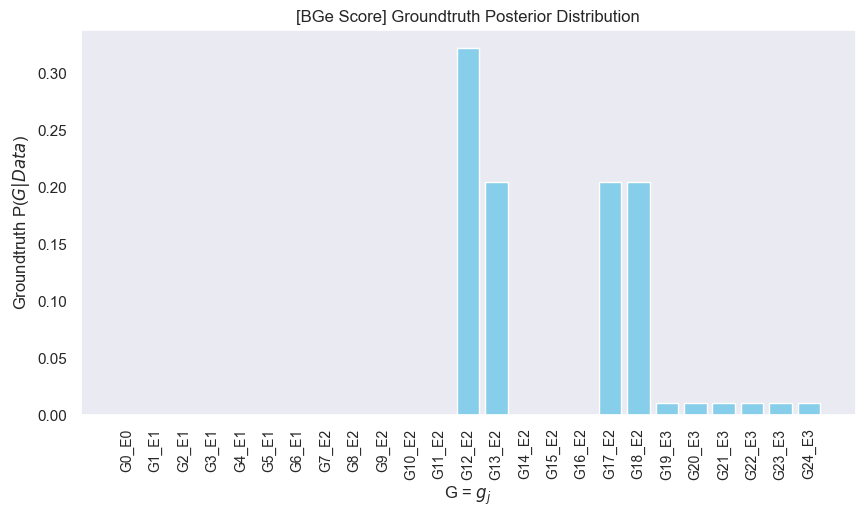

In [66]:
#my_score_str = "BGe Score"

plot_true_posterior_distribution( all_dags, score = 'score_normalised', figsize=(10, 5), 
                                    prob_threshold = 0, 
                                    title = f"[{my_score_str}] Groundtruth Posterior Distribution" )


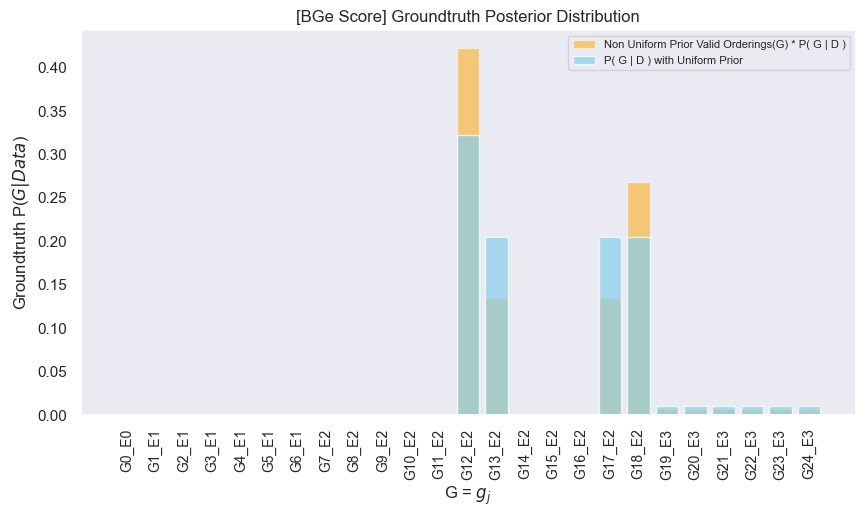

(None, None)

In [67]:
plot_true_distribution_with_non_uniform_prior( all_dags, prob_threshold = 0 )

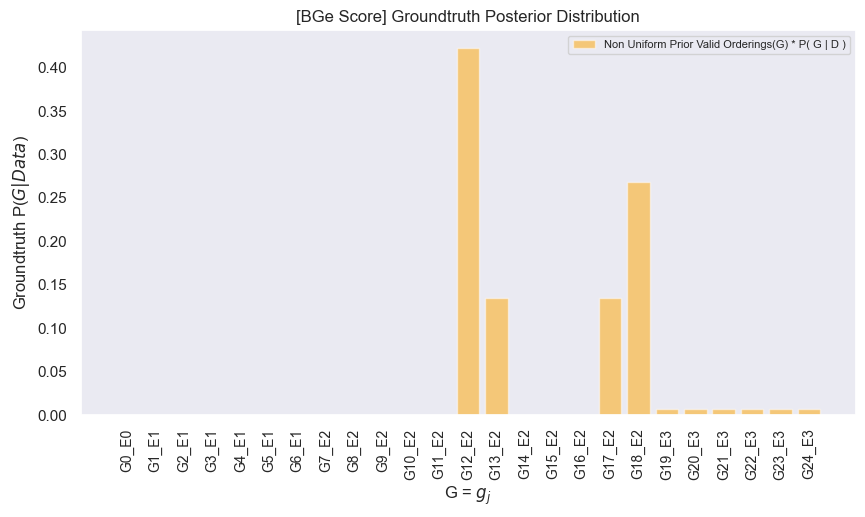

In [68]:
plot_non_uniform_prior_distribution( all_dags, prob_threshold  = 0 )

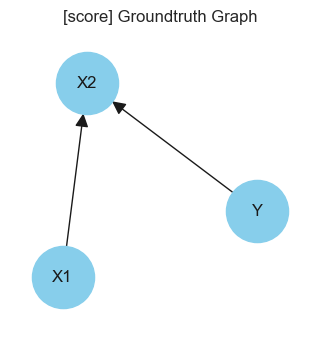

In [69]:
plot_dag_from_true_distr( all_dags, 10)

In [ ]:
plot_dag_from_true_distr( all_dags, 12)

In [ ]:
plot_dag_from_true_distr( all_dags, 198)

In [ ]:
all_dags[graph_key1]['log_score'] - all_dags[graph_key2]['log_score']

-23.59009162971506

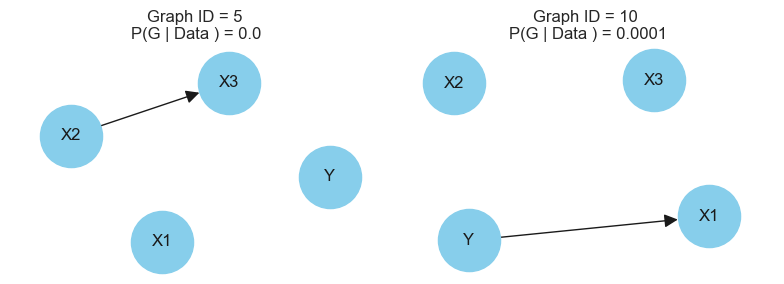

In [25]:
plot_dag_from_true_distr_side_by_side(all_dags, 5, 10)

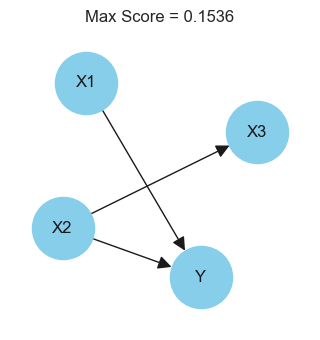

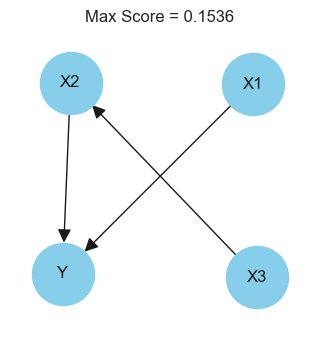

{'MAP_Score': 0.1536455854918432,
 'DAG_ID': [147, 153],
 'DAG': ['0001,0011,0000,0000', '0001,0001,0100,0000']}

In [40]:
get_MAP_dags_from_distr(true_posterior_distribution, node_labels= data.columns)

## Run Structure MCMC

### Starting with an empty DAG

In [41]:
G_init = nx.DiGraph()

G_init.add_node('X1')
G_init.add_node('X2')
G_init.add_node('X3')

G_init.add_node('Y')

#G_init.add_edge("X1", "Y")
#G_init.add_edge("X2", "Y")
#G_init.add_edge("X2", "X3")



results_analyser = MCMCResultsEngine( )

In [42]:
mcmc_cache = Cache()

burnIn = 0

In [49]:


# Initialize the directed graph with the given nodes
#G_init = nx.DiGraph()
#G_init.add_nodes_from(['X1', 'X2', 'X3', 'Y'])

# Define the edge list
#edges_white = [("X1", "X3")]
#edges_black = [("X1", "X2")]


#black_list = edges_to_adjacency_matrix(edges_black, G_init)
#white_list = edges_to_adjacency_matrix(edges_white, G_init)

#white_list


In [46]:
initial_graph = G_init
initial_order = random.choice(all_valid_orderings(initial_graph))
max_iter = 10000

N = len( data.columns )

proposal_object = GraphProposalUniform(initial_graph, whitelist=None, blacklist=None)
#score_object = BGEscoreEfficient( data=data, graph=initial_graph )
score_object = MarginalLogLikelihood( data=data, graph=initial_graph )

struct_mcmc = StructureMCMC(initial_graph, max_iter, proposal_object, score_object, burnIn)

mcmc_res, accept_rate = struct_mcmc.run()
print(f"ACCEPTANCE RATE = {accept_rate}")

{'score': -1475.924978946991, 'parameters': {'X1': {'score': -307.3326778269062, 'Lambda_n': array([[200.1]]), 'm_n': array([0.00999879]), 'a_n': 101.0, 'b_n': 119.93702194157689}, 'X2': {'score': -272.79577035588, 'Lambda_n': array([[200.1]]), 'm_n': array([-0.04069082]), 'a_n': 101.0, 'b_n': 85.2013440497579}, 'X3': {'score': -426.5624731106734, 'Lambda_n': array([[200.1]]), 'm_n': array([-0.37333375]), 'a_n': 101.0, 'b_n': 390.51243418484427}, 'Y': {'score': -469.2340576535314, 'Lambda_n': array([[200.1]]), 'm_n': array([-0.03860113]), 'a_n': 101.0, 'b_n': 595.827232414474}}}
ACCEPTANCE RATE = 0.2001


In [49]:
# compute the approximate posterior distribution
# test
graph_list = struct_mcmc.get_mcmc_res_graphs( mcmc_res )[burnIn:]
approx_posterior_distribution = update_graph_frequencies(graph_list, all_dags)


In [ ]:
def plot_approx_posterior_distribution(all_dags_dict, num_dags_threshold=50, prob_threshold=0.001, figsize=(7,5), title="MCMC Approximate Posterior Distribution"):
    
    # copy all_dags_dict and remove the first entry
    all_dags_dict_copy = all_dags_dict.copy()
    all_dags_dict_copy.pop(0, None) 

    # Create a mapper
    id_to_adjmat = {key: idx for idx, key in enumerate(all_dags_dict_copy.keys())}
    adjmat_to_id = {idx: key for idx, key in enumerate(all_dags_dict_copy.keys())}
    
    # Filter all_dags_dict for scores greater than 0.0001
    filtered_dags = {k: v for k, v in all_dags_dict_copy.items() if v >= prob_threshold}
    
    # Determine which entries to plot based on the length of filtered_dags and their score_normalised value
    if len(filtered_dags) >= num_dags_threshold:
        further_filtered_dags = {k: v for k, v in filtered_dags.items() if v >= prob_threshold}
        x_labels = [str(id_to_adjmat[key]) for key in further_filtered_dags.keys()]
        scores = [entry for entry in further_filtered_dags.values()]
    else:
        x_labels = [str(id_to_adjmat[key]) for key in filtered_dags.keys()]
        scores = [entry for entry in filtered_dags.values()]
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.bar(x_labels, scores, color='skyblue')
    
    # Show ticks only for x values greater than 0
    plt.xticks(range(len(x_labels)), rotation=90, fontsize=10)

    plt.xlabel('G = $g_j$')
    plt.ylabel(r'MCMC Approximate P($G | Data$)')
    plt.title(title)
    plt.grid(False)
    plt.show()
    
    return adjmat_to_id

In [52]:
appr_mapper = plot_approx_posterior_distribution(approx_posterior_distribution,  prob_threshold = 0.001, title = f'[{score_object.to_string}] Approximate Posterior Distribution for {len(data.columns)} Nodes. Num iterations = {max_iter}', figsize=(10, 5))



TypeError: '>=' not supported between instances of 'dict' and 'float'

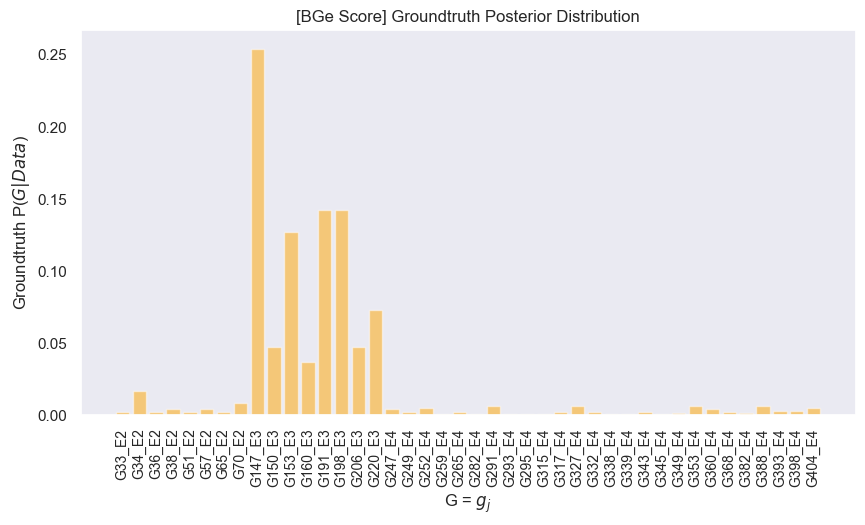

In [88]:
prob_threshold = 0.001
filtered_dags = {k: v for k, v in all_dags.items() if v['score_normalised'] >= prob_threshold}
        
fig, ax = plt.subplots(figsize=(10, 5))
mapper = plot_true_posterior_distribution( filtered_dags, 
                                        score = 'score_ordering_normalised', #figsize=(15, 7), 
                                        prob_threshold = prob_threshold, 
                                        title = f"[{my_score_str}] Groundtruth Posterior Distribution", 
                                        alpha=0.5, my_color = 'orange',  ax=ax )

In [114]:
loss = []
for i in range(1, 100):

    graph_list = struct_mcmc.get_mcmc_res_graphs( mcmc_res )[0:i*1000]
    approx_posterior_distribution = update_graph_frequencies(graph_list, N, list(data.columns))
    
    loss.append(  jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution ) )

Text(0.5, 1.0, 'Augmented MCMC Jensen-Shannon Loss (pi=0.1)')

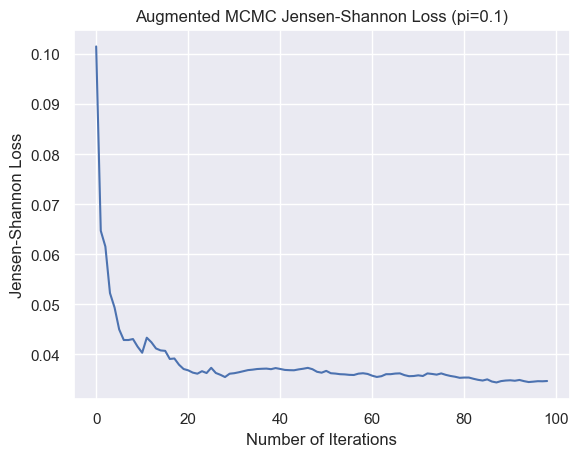

In [115]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("Augmented MCMC Jensen-Shannon Loss (pi=0.1)")


Text(0.5, 1.0, '[Marginal Likelihood] Augmented MCMC Jensen-Shannon Loss (pi=1)')

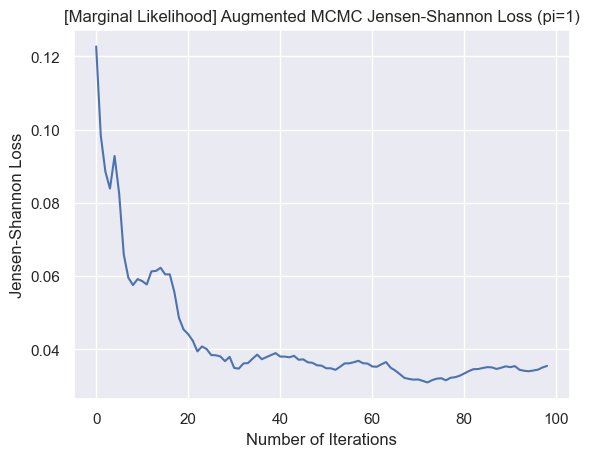

In [111]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("[Marginal Likelihood] Augmented MCMC Jensen-Shannon Loss (pi=1)")



Text(0.5, 1.0, 'Augmented MCMC Jensen-Shannon Loss (pi=1)')

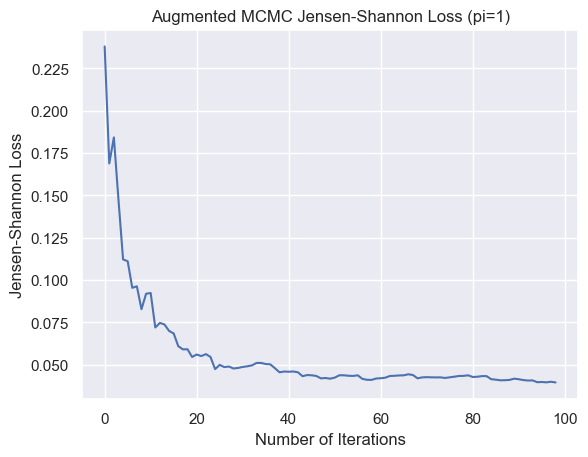

In [102]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("Augmented MCMC Jensen-Shannon Loss (pi=1)")



In [ ]:
# inspect graphs
ID = 13
plot_graph( adjacency_string_to_digraph( mapper[ID] , 
                                        labels = data.columns), figsize=(3, 3),
                                        title = f"Graph ID = {ID} \nP(G | Data ) = {np.round(approx_posterior_distribution[mapper[ID]], 4)}" )

TypeError: 'NoneType' object is not subscriptable

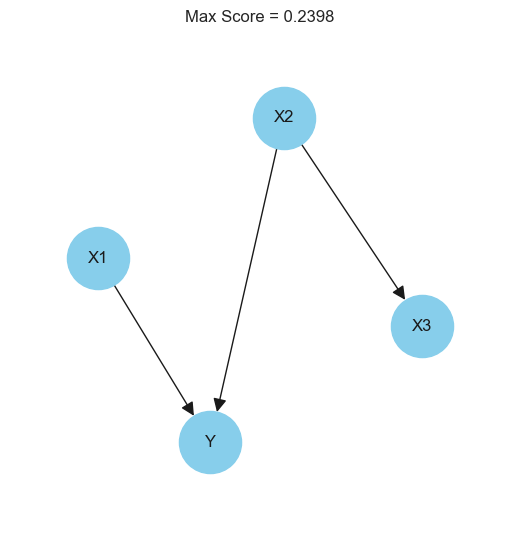

In [94]:
# get max probability graphs
max_score = max(approx_posterior_distribution.values())

max_dags = []
for dag, score in approx_posterior_distribution.items() :
    if score == max_score:
        max_dags.append(dag)


for g_max in max_dags:
    plot_graph( adjacency_string_to_digraph( g_max, labels=list(data.columns) ), figsize=(5, 5), title=f'Max Score = {np.round(max_score, 4)}' )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


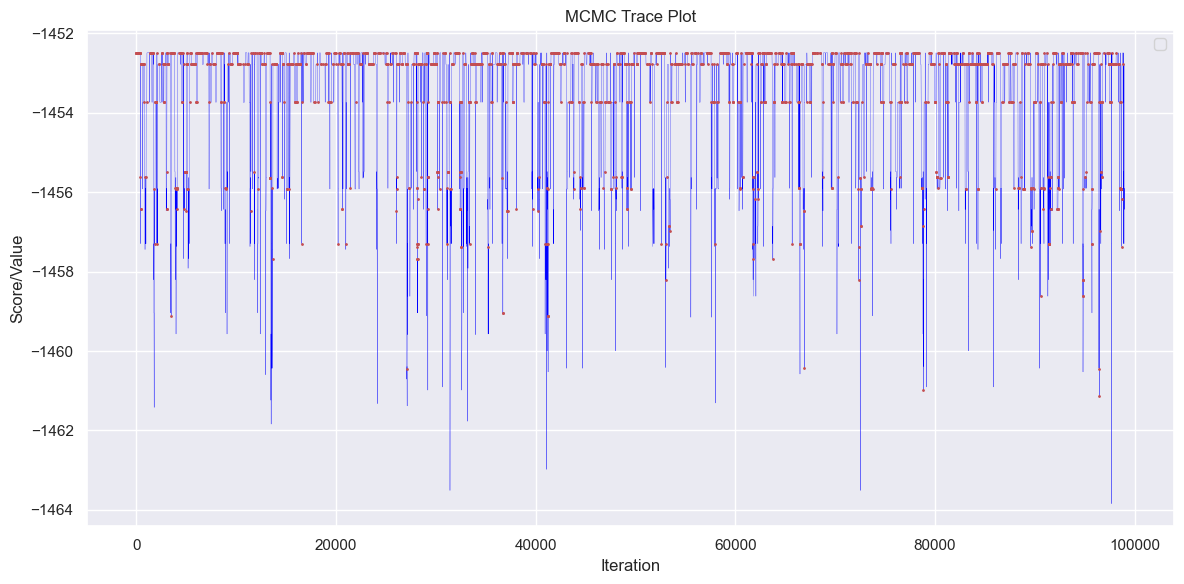

In [90]:
results_analyser.trace_plot(struct_mcmc, mcmc_res, burnIn )


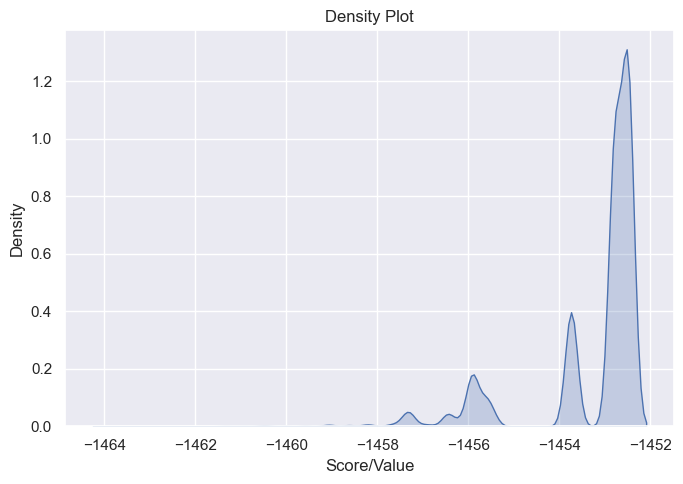

In [91]:
results_analyser.density_plot(struct_mcmc, mcmc_res, burnIn, figsize=(7, 5) )

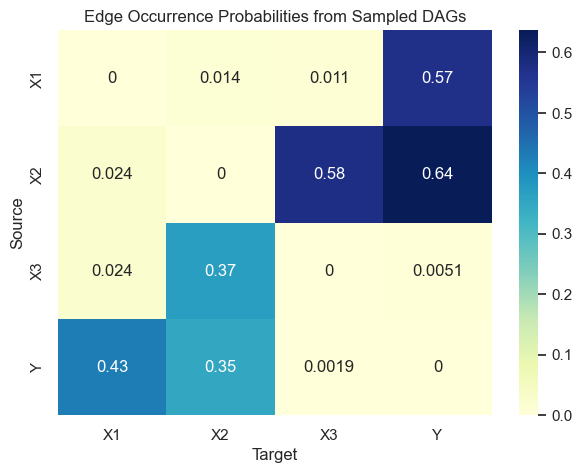

In [92]:
results_analyser.mcmc_edge_frequency_heatmap( struct_mcmc, mcmc_res, burnIn, figsize=(7, 5) )

## Comparing Both Distributions



### Jensen Shannon Divergence

In [93]:
diverg = jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution )
diverg

0.0389823833070668

### Mean Square Error

In [71]:
mse = mean_squared_error(true_posterior_distribution, approx_posterior_distribution )
mse

0.01612259297253496

### Mean Absolute Error

In [72]:
mae = mean_absolute_error( true_posterior_distribution, approx_posterior_distribution )
mae

0.4217376647930678

### True Posterior Distribution vs Approximated Posterior Distribution

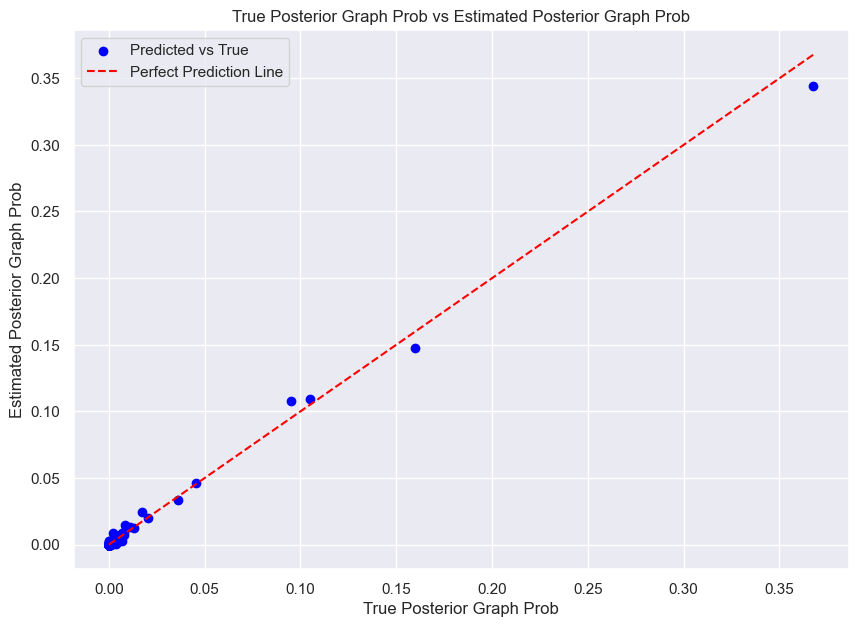

In [ ]:
results_analyser.plot_true_posterior_vs_approx_posterior(true_posterior_distribution, approx_posterior_distribution )


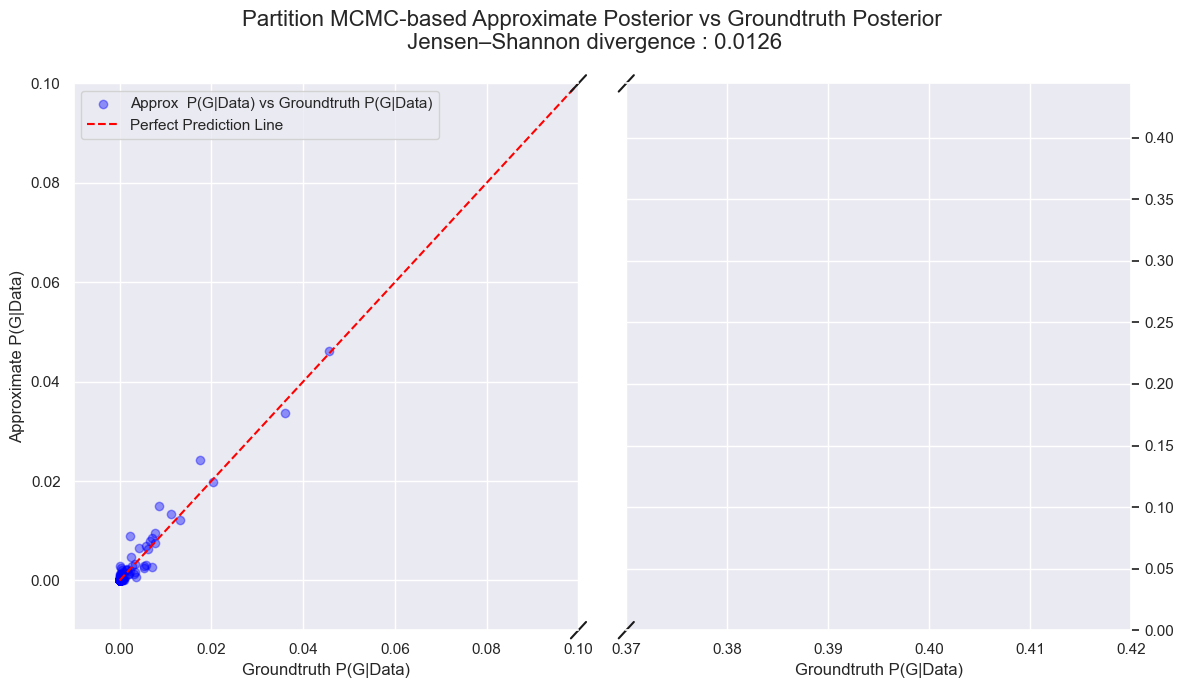

In [ ]:
import matplotlib.gridspec as gridspec



# Create a figure and a gridspec
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])

ZOOM1_X1 = -0.01
ZOOM1_X2 = 0.1

ZOOM1_Y1 = -0.01
ZOOM1_Y2 = 0.1

ax0 = plt.subplot(gs[0])
ax0.scatter(list(true_posterior_distribution.values()), list(approx_posterior_distribution.values()), color='blue', alpha = 0.4,  label='Approx  P(G|Data) vs Groundtruth P(G|Data)')
ax0.set_xlim(ZOOM1_X1, ZOOM1_X2)
ax0.set_ylim(ZOOM1_Y1, ZOOM1_Y2)

ax0.spines['right'].set_visible(False)
ax0.set_ylabel('Approximate P(G|Data)')
ax0.set_xlabel('Groundtruth P(G|Data)')

ax0.plot([min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], 
         [min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], color='red', linestyle='--', label='Perfect Prediction Line')

ax0.grid(True)
plt.legend()


ZOOM2_X1 = 0.37
ZOOM2_X2 = 0.42

# Create the right subplot (0.7 to 1)
ax1 = plt.subplot(gs[1])
ax1.scatter(list(true_posterior_distribution.values()), list(approx_posterior_distribution.values()), color='blue', alpha = 0.4)
ax1.set_xlim(ZOOM2_X1,ZOOM2_X2 )
ax1.set_ylim(min(approx_posterior_distribution.values()), max(approx_posterior_distribution.values())+0.1)
ax1.spines['left'].set_visible(False)
ax1.yaxis.tick_right()
ax1.set_xlabel('Groundtruth P(G|Data)')

ax1.plot([min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], 
         [min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], color='red', linestyle='--', label='Perfect Prediction Line')

ax1.grid(True)

# Adding the "broken" axis effect using diagonals
d = .015
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax1.transAxes)
ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.plot((-d, +d), (-d, +d), **kwargs)

# Title for the entire figure
fig.suptitle(f'Partition MCMC-based Approximate Posterior vs Groundtruth Posterior\n Jensen–Shannon divergence : {np.round(diverg,4)}', fontsize=16)

plt.tight_layout()

plt.show()

# todo, put in a different color the score of the data genrator graph


## Error vs Num Samples

- change the noise
- change the number of samples
- change the number of nodes


### Sample parameters from graph

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['X1', 'X2', 'X3', 'Y'])
G.add_edges_from((("X1", "Y"),("X2","Y"),("X2","X3")))
DAG = get_adjacency_matrix(G)
n = len(data.columns)
Imat = np.eye(n)
U = pd.DataFrame(Imat, index=data.columns, columns=data.columns)
U

,X1,X2,X3,Y
X1,1.0,0.0,0.0,0.0
X2,0.0,1.0,0.0,0.0
X3,0.0,0.0,1.0,0.0
Y,0.0,0.0,0.0,1.0


In [ ]:
score_object = BGEscore( data=data, graph=G )
rDAG_NIG(1, DAG, score_object, U)['L'][0]

,X1,X2,X3,Y
X1,1.0,0.0,0.000000,-0.819945
X2,0.0,1.0,-0.306811,-0.676914
X3,0.0,0.0,1.000000,0.000000
Y,0.0,0.0,0.000000,1.000000
